## ML model testing

* logistic / multinomial logistic regression



In [1134]:
import pandas as pd
pd.set_option('display.max_columns',50)
#pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 50)
import numpy as np
from numpy import argmax
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss, roc_auc_score, r2_score, f1_score, classification_report, accuracy_score, RocCurveDisplay, plot_precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
from sklearn.utils import resample

from collections import Counter

In [1135]:
df = pd.read_csv('/Users/wjdol/Desktop/LighthouseLabs/Flight_delays/data/flights_complete_raw.csv', parse_dates=['fl_date'])

In [1136]:
df['fl_day'] = df['fl_date'].dt.weekday

In [1098]:
df.head()

,Unnamed: 0,identifier,mkt_unique_carrier,op_unique_carrier,origin,origin_city,dest,dest_city,distance,fl_date,fl_day,week_num,dep_time_of_day,arr_time_of_day,departures_performed,payload,passengers,freight,air_time,aircraft_type,distance_group,arr_delay,delay_binary,sdomt_gallons,tdomt_gallons,sdomt_cost,tdomt_cost,weather_id,date_orig_id,index,date_str,AWND,PRCP,SNOW,SNWD,TAVG
0,0,DL-FLL-ATL,DL,DL,FLL,Fort Lauderdale,ATL,Atlanta,581.0,2019-01-13,6,2,evening,evening,3.0,118728.0,312.5,1559.5,255.0,614.0,2.0,-8.0,0.0,147684843.4,149458650.6,284064640.2,288453038.8,2019-01-13-FLL,2019-01-13-FLL,FLL,2019-01-13,31.0,43.0,0.0,0.0,234.0
1,1,AA-DCA-DFW,AA,AA,DCA,Washington,DFW,Dallas/Fort Worth,1192.0,2019-01-14,0,3,morning,morning,111.5,4801900.0,14754.5,4587.0,20461.5,614.0,3.0,75.0,1.0,162609079.0,163140817.6,264949334.8,265791415.6,2019-01-14-DCA,2019-01-14-DCA,DCA,2019-01-14,30.0,0.0,3.0,250.0,-2.0
2,2,OO-ORD-IND,AA,OO,ORD,Chicago,IND,Indianapolis,177.0,2019-01-10,3,2,afternoon,afternoon,23.0,349600.0,1603.0,0.0,799.0,673.0,1.0,-7.0,0.0,6214610.8,6214610.8,12885113.2,12885113.2,2019-01-10-ORD,2019-01-10-ORD,ORD,2019-01-10,20.0,0.0,0.0,0.0,-78.0
3,3,UA-PIT-SFO,UA,UA,PIT,Pittsburgh,SFO,San Francisco,2254.0,2019-01-11,4,2,afternoon,evening,3.0,104033.0,429.0,375.0,876.0,694.0,5.0,-7.0,0.0,115001515.0,115971276.2,191543386.6,193359267.6,2019-01-11-PIT,2019-01-11-PIT,PIT,2019-01-11,29.0,0.0,0.0,0.0,-52.0
4,4,OO-MSP-GFK,DL,OO,MSP,Minneapolis,GFK,Grand Forks,284.0,2019-01-03,3,1,evening,overnight,29.0,565920.0,1876.0,0.0,1429.0,638.0,1.0,-15.0,0.0,6214610.8,6214610.8,12885113.2,12885113.2,2019-01-03-MSP,2019-01-03-MSP,MSP,2019-01-03,33.0,0.0,0.0,0.0,-23.0


In [1137]:
# drop columns not used

df = df.drop(['Unnamed: 0', 'op_unique_carrier', 'origin_city', 'dest_city', 'fl_date', 'arr_delay','identifier', 'index', 'date_orig_id', 'weather_id', 'date_str', 'aircraft_type', 'distance', 'sdomt_gallons', 'sdomt_cost', 'freight', 'air_time'], axis=1)

In [1019]:
df[df['tdomt_gallons']==0]['mkt_unique_carrier'].unique()

array(['AA', 'UA', 'DL', 'AS'], dtype=object)

In [1138]:
df.loc[df['tdomt_gallons']==0, 'tdomt_gallons'] = np.mean(df['tdomt_gallons'])

In [1139]:
df.loc[df['tdomt_cost']==0,'tdomt_cost'] = np.mean(df['tdomt_cost'])

In [1140]:

df = df.drop(df[df['passengers']==0].index)

In [1141]:
dfclf = df.copy()

In [957]:
# dfclf.isnull().sum()

In [1142]:
# bins for numerical data

dfclf['SNWD'] = pd.cut(dfclf['SNWD'], bins=[0, 0.1, 60, 150, np.inf], labels=['0','1','2','3'], include_lowest=True)

dfclf['PRCP'] = pd.cut(dfclf['PRCP'], bins=[0, 0.1, 75, 250, np.inf], labels=['0','1','2','3'], include_lowest=True)

In [1143]:
# make bins for grouping

airlines_list = dict(pd.qcut(dfclf['mkt_unique_carrier'].value_counts(), q=[0, 0.45, 0.9, 1.0], labels=['1','2','3']))

origin_list = dict(pd.qcut(dfclf['origin'].value_counts(), q=[0, 0.25, 0.5, 1.0], labels=['1','2','3']))

dest_list = dict(pd.qcut(dfclf['dest'].value_counts(), q=[0, 0.25, 0.5, 1.0], labels=['1','2','3']))


In [1144]:
dfclf['mkt_unique_carrier'].replace(airlines_list, inplace=True)
dfclf['origin'].replace(origin_list, inplace=True)
dfclf['dest'].replace(dest_list, inplace=True)

In [719]:
# create list of value counts by columns

# identifier_count = Counter(dict(dfclf['identifier'].value_counts()))
# carrier_count = Counter(dict(dfclf['mkt_unique_carrier'].value_counts()))
# #originc_count = Counter(dict(dfclf['origin_city'].value_counts()))
# origin_count = Counter(dict(dfclf['origin'].value_counts()))
# #destc_count = Counter(dict(dfclf['dest_city'].value_counts()))
# dest_count = Counter(dict(dfclf['dest'].value_counts()))
# wkday_count = Counter(dict(dfclf['fl_day'].value_counts()))
# #type_count = Counter(dict(dfclf['aircraft_type'].value_counts()))
# payl_count = Counter(dict(dfclf['payload'].value_counts()))

In [1108]:
dfclf.head()

,mkt_unique_carrier,origin,dest,fl_day,week_num,dep_time_of_day,arr_time_of_day,departures_performed,payload,passengers,distance_group,delay_binary,tdomt_gallons,tdomt_cost,AWND,PRCP,SNOW,SNWD,TAVG,costPerGallon,costPerPerson,gallonPerPerson
0,2,3,3,6,2,evening,evening,3.0,118728.0,312.5,2.0,0.0,149458650.6,288453038.8,31.0,1,0.0,0,234.0,1.929986,923049.724160,478267.681920
1,3,3,3,0,3,morning,morning,111.5,4801900.0,14754.5,3.0,1.0,163140817.6,265791415.6,30.0,0,3.0,3,-2.0,1.629215,18014.261114,11057.021085
2,3,3,3,3,2,afternoon,afternoon,23.0,349600.0,1603.0,1.0,0.0,6214610.8,12885113.2,20.0,0,0.0,0,-78.0,2.073358,8038.124267,3876.862633
3,2,1,3,4,2,afternoon,evening,3.0,104033.0,429.0,5.0,0.0,115971276.2,193359267.6,29.0,0,0.0,0,-52.0,1.667303,450720.903497,270329.315152
4,2,3,2,3,1,evening,overnight,29.0,565920.0,1876.0,1.0,0.0,6214610.8,12885113.2,33.0,0,0.0,0,-23.0,2.073358,6868.397228,3312.692324


In [1145]:
# add new features based on fuel consumption, fuel cost, and passengers

dfclf['costPerGallon'] = dfclf['tdomt_cost']/dfclf['tdomt_gallons']
dfclf['costPerPerson'] = dfclf['tdomt_cost']/dfclf['passengers']
dfclf['gallonPerPerson'] = dfclf['tdomt_gallons']/dfclf['passengers']


In [645]:
# determine quartile splits

# top_carriers = top_categories(carrier_count, 0.90)
# top_dest = top_categories(dest_count, 0.5)
# top_origin = top_categories(origin_count, 0.5)
# top_identifier = top_categories(identifier_count, 0.05)

In [1146]:
dfclf['delay_binary'] = dfclf['delay_binary'].astype(int)

In [990]:
dfclf.head()

,mkt_unique_carrier,origin,dest,fl_day,week_num,dep_time_of_day,arr_time_of_day,departures_performed,payload,passengers,distance_group,delay_binary,tdomt_gallons,tdomt_cost,AWND,PRCP,SNOW,SNWD,TAVG,costPerGallon,costPerPerson,gallonPerPerson
0,2,3,3,6,2,evening,evening,3.0,118728.0,312.5,2.0,0.0,149458650.6,288453038.8,31.0,1,0.0,0,234.0,1.929986,923049.724160,478267.681920
1,3,3,3,0,3,morning,morning,111.5,4801900.0,14754.5,3.0,1.0,163140817.6,265791415.6,30.0,0,3.0,3,-2.0,1.629215,18014.261114,11057.021085
2,3,3,3,3,2,afternoon,afternoon,23.0,349600.0,1603.0,1.0,0.0,6214610.8,12885113.2,20.0,0,0.0,0,-78.0,2.073358,8038.124267,3876.862633
3,2,1,3,4,2,afternoon,evening,3.0,104033.0,429.0,5.0,0.0,115971276.2,193359267.6,29.0,0,0.0,0,-52.0,1.667303,450720.903497,270329.315152
4,2,3,2,3,1,evening,overnight,29.0,565920.0,1876.0,1.0,0.0,6214610.8,12885113.2,33.0,0,0.0,0,-23.0,2.073358,6868.397228,3312.692324


In [1147]:
dfclf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33503 entries, 0 to 33510
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   mkt_unique_carrier    33503 non-null  object  
 1   origin                33503 non-null  object  
 2   dest                  33503 non-null  object  
 3   fl_day                33503 non-null  int64   
 4   week_num              33503 non-null  int64   
 5   dep_time_of_day       33503 non-null  object  
 6   arr_time_of_day       33503 non-null  object  
 7   departures_performed  33503 non-null  float64 
 8   payload               33503 non-null  float64 
 9   passengers            33503 non-null  float64 
 10  distance_group        33503 non-null  float64 
 11  delay_binary          33503 non-null  int32   
 12  tdomt_gallons         33503 non-null  float64 
 13  tdomt_cost            33503 non-null  float64 
 14  AWND                  33503 non-null  float64 
 15  PR

In [1148]:
dfclf = pd.get_dummies(dfclf, columns=['dep_time_of_day','arr_time_of_day'], drop_first=True)

In [1149]:
# split features and target

y = dfclf['delay_binary']
X = dfclf.drop('delay_binary', axis=1)

In [1150]:
# train / test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [1151]:
num_X_train = X_train.select_dtypes(include=['float64'])
num_X_test = X_test.select_dtypes(include=['float64'])

In [977]:
num_X_train

,fl_day,week_num,departures_performed,payload,passengers,air_time,distance_group,tdomt_gallons,tdomt_cost,AWND,SNOW,TAVG,costPerGallon,costPerPerson,gallonPerPerson,dep_time_of_day_evening,dep_time_of_day_morning,dep_time_of_day_overnight,arr_time_of_day_evening,arr_time_of_day_morning,arr_time_of_day_overnight
10787,2,2,214.0,7404400.0,22294.5,13395.0,1.0,156532592.0,293803944.4,18.0,0.0,152.0,1.876951,13178.315028,7021.130413,0,0,0,1,0,0
6024,2,3,30.0,1088100.0,2706.0,3191.0,2.0,163140817.6,265791415.6,13.0,0.0,137.0,1.629215,98222.991722,60288.550480,1,0,0,0,0,1
5920,2,5,1.0,34860.0,111.0,267.0,5.0,44216757.8,83115270.4,11.0,0.0,56.0,1.879723,748786.219820,398349.169369,0,0,0,1,0,0
6783,3,1,38.0,1525000.0,4750.0,1466.0,1.0,156532592.0,293803944.4,47.0,0.0,110.0,1.876951,61853.461979,32954.229895,0,1,0,0,0,0
9278,3,4,79.5,749500.0,2910.5,4269.5,1.0,54337.0,144824.4,16.0,0.0,59.0,2.665300,49.759285,18.669301,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14904,5,4,27.5,1427600.0,4192.5,7743.5,4.0,163140817.6,265791415.6,14.0,0.0,8.0,1.629215,63396.879094,38912.538485,0,0,0,1,0,0
12963,2,3,35.0,1597300.0,5380.0,10172.0,6.0,163140817.6,265791415.6,99.0,0.0,124.0,1.629215,49403.608848,30323.572045,0,1,0,0,0,0
17367,3,2,3.0,118728.0,312.5,255.0,2.0,149458650.6,288453038.8,45.0,0.0,223.0,1.929986,923049.724160,478267.681920,0,0,0,1,0,0
1092,3,4,128.0,2790784.0,8922.0,7417.0,1.0,5327632.2,7937670.4,62.0,0.0,154.0,1.489906,889.673885,597.134297,1,0,0,1,0,0


In [1152]:
dfclf.isnull().sum()

mkt_unique_carrier           0
origin                       0
dest                         0
fl_day                       0
week_num                     0
departures_performed         0
payload                      0
passengers                   0
distance_group               0
delay_binary                 0
tdomt_gallons                0
tdomt_cost                   0
AWND                         0
PRCP                         0
SNOW                         0
SNWD                         0
TAVG                         0
costPerGallon                0
costPerPerson                0
gallonPerPerson              0
dep_time_of_day_evening      0
dep_time_of_day_morning      0
dep_time_of_day_overnight    0
arr_time_of_day_evening      0
arr_time_of_day_morning      0
arr_time_of_day_overnight    0
dtype: int64

In [1153]:
cat_X_train = X_train.select_dtypes(exclude=['float64'])
cat_X_test = X_test.select_dtypes(exclude=['float64'])

In [1154]:
scaler = StandardScaler()

scaler.fit(num_X_train)

scaled_X_train = scaler.transform(num_X_train)
scaled_X_test = scaler.transform(num_X_test)


In [1155]:
cat_X_train_f = cat_X_train.to_numpy()
cat_X_test_f = cat_X_test.to_numpy()

In [1156]:
X_train_f = np.hstack((cat_X_train_f, scaled_X_train))
X_test_f = np.hstack((cat_X_test_f, scaled_X_test))

In [1158]:
# create logistic regression model

clf_0 = LogisticRegression(solver='saga', penalty='l2', max_iter=10000)

clf_0.fit(X_train_f, y_train)

LogisticRegression(max_iter=10000, solver='saga')

In [1159]:
test_prob = clf_0.predict_proba(X_test_f)[:,1]
test_pred = clf_0.predict(X_test_f)

In [1160]:
coeffs = np.hstack((clf_0.intercept_, clf_0.coef_[0]))
coeffs_tbl = pd.DataFrame(data={'variable': ['intercept'] + list(X.columns) , 'coefficient': coeffs})

In [446]:
log_loss(y_test, test_pred)

11.311950639333617

In [432]:
X_train_f

array([[-1.09147605, -0.90990237,  0.90074761, ..., -0.73592673,
        -0.52893907, -0.22544553],
       [ 1.93894542,  1.14288899,  0.90074761, ..., -0.73592673,
        -0.52893907, -0.22544553],
       [-0.19849392, -1.4231002 , -0.62545996, ...,  1.35883092,
        -0.52893907, -0.22544553],
       ...,
       [-0.49951802, -0.90990237, -0.62545996, ..., -0.73592673,
         1.89057694, -0.22544553],
       [ 0.31274256,  0.11649331,  0.13764383, ...,  1.35883092,
        -0.52893907, -0.22544553],
       [-0.48774613, -1.4231002 , -0.62545996, ..., -0.73592673,
        -0.52893907, -0.22544553]])

In [405]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.96      0.80       969
         1.0       0.45      0.06      0.11       463

    accuracy                           0.67      1432
   macro avg       0.57      0.51      0.45      1432
weighted avg       0.61      0.67      0.58      1432



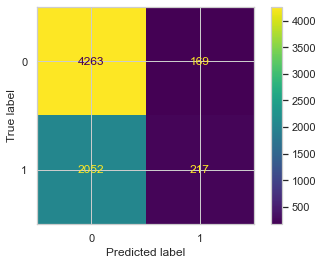

In [1161]:
ConfusionMatrixDisplay.from_estimator(clf_0, X_test_f, y_test);

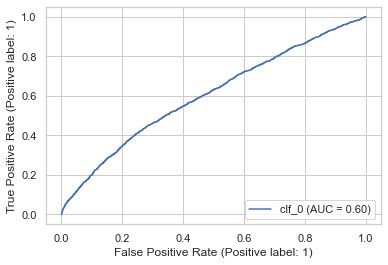

In [1162]:
RocCurveDisplay.from_estimator(clf_0, X_test_f, y_test, name='clf_0');

In [1163]:
params = {'solver':('sag','saga'), 'penalty':('none', 'l2'), 'C':[0.01, 0.1, 1.0], 'max_iter':[10000]}

clf_1 = GridSearchCV(LogisticRegression(), params, n_jobs=-1)

In [1164]:
clf_1.fit(X_train_f, y_train)

C:\Users\wjdol\Desktop\LighthouseLabs\env\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0], 'max_iter': [10000],
                         'penalty': ('none', 'l2'), 'solver': ('sag', 'saga')})

In [1165]:
clf_1.best_estimator_

LogisticRegression(C=0.01, max_iter=10000, penalty='none', solver='sag')

In [1166]:
test_prob1 = clf_1.predict_proba(X_test_f)[:,1]
test_pred1 = clf_1.predict(X_test_f)

In [1167]:
print(classification_report(y_test, test_pred1))

              precision    recall  f1-score   support

           0       0.68      0.96      0.79      4432
           1       0.56      0.10      0.16      2269

    accuracy                           0.67      6701
   macro avg       0.62      0.53      0.48      6701
weighted avg       0.64      0.67      0.58      6701



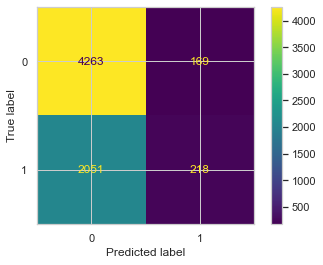

In [1168]:
ConfusionMatrixDisplay.from_estimator(clf_1, X_test_f, y_test);

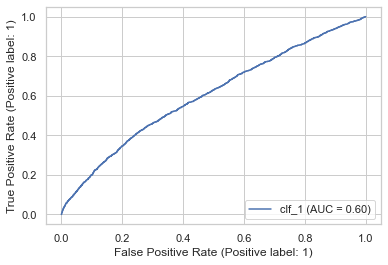

In [1169]:
RocCurveDisplay.from_estimator(clf_1, X_test_f, y_test, name='clf_1');

In [238]:
def top_categories(X, perc):
       
    val_list = []
    key_list = []
    denom = sum(X.values())
    
    for count, (keys, values) in enumerate(X.items()):
        if (sum(val_list)/denom) < perc:
            key_list.append(keys)
            val_list.append(values)
            
    return key_list
    

(0.0, 1.0)

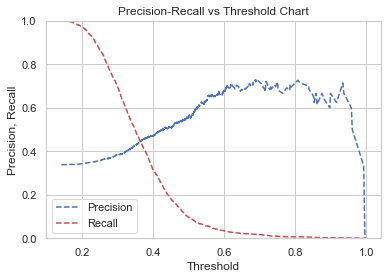

In [1170]:
# Predict test_y values and probabilities based on fitted logistic regression model

pred_y=clf_0.predict(X_test_f) 

probs_y=clf_0.predict_proba(X_test_f) 

# probs_y is a 2-D array of probability of being labeled as 0 
# (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve, roc_curve
import sklearn.metrics as metrics

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 

#retrieve probability of being 1(in second column of probs_y)

pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


In [1171]:
fpr, tpr, thresholds = roc_curve(y_test, probs_y[:, 1])
Jt = tpr - fpr
ix = argmax(Jt)
best_threshold = thresholds[ix]
print('Best threshold=%f' % (best_threshold))

Best threshold=0.363414


<BarContainer object of 25 artists>

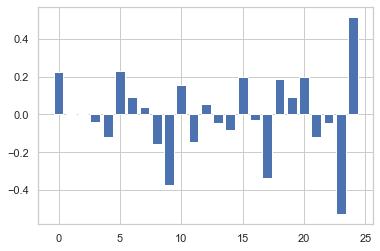

In [1172]:
# display feature importance

# model clf_0:

importance_0 = clf_0.coef_[0]
   
    
coefficients = np.hstack((clf_0.intercept_, clf_0.coef_[0]))
coeffs_df = pd.DataFrame(data={'variable': ['intercept'] + list(X), 'coefficient': coefficients})
    
plt.bar([x for x in range(len(importance_0))], importance_0)



In [1173]:
coeffs_df.sort_values(by='coefficient', ascending=False)

,variable,coefficient
25,arr_time_of_day_overnight,0.515902
6,departures_performed,0.226833
1,mkt_unique_carrier,0.223454
16,TAVG,0.197201
21,dep_time_of_day_morning,0.195865
19,gallonPerPerson,0.184297
11,tdomt_cost,0.152776
20,dep_time_of_day_evening,0.094008
7,payload,0.092794
13,PRCP,0.053579


In [1174]:
def log_pvalue(model, x):
   
    p1 = model.predict_proba(x)
    n1 = len(p1)
    m1 = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    answ = np.zeros((m1, m1))
    for i in range(n1):
        answ = answ + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p1[i,1] * p1[i, 0]
    vcov = np.linalg.inv(np.matrix(answ))
    se = np.sqrt(np.diag(vcov))
    t1 =  coefs/se  
    p1 = pd.DataFrame(((1 - norm.cdf(abs(t1))) * 2), columns=['p_values'])
    return p1

In [1177]:
# log_pvalue(clf_1, X_train_f)